In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, GlobalAveragePooling1D, TimeDistributed, Dropout, GRU
from keras import layers
from keras import ops

from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler

# Define the Network

In [ ]:
# class TrainableHysteronCell(tf.keras.layers.Layer):

#     def __init__(self, sharpness = 20.0, **kwargs):
#         super().__init__(**kwargs)
#         self.state_size = 1
#         self.sharpness = sharpness
    
#     def build(self, input_shape):
#         self.alpha = self.add_weight(name="alpha", shape=(), initializer="random_uniform", trainable=True)
#         self.beta = self.add_weight(name="beta", shape=(), initializer="random_uniform", trainable=True)
#         self.output_weight = self.output_weight(name="output_weight", shape=(), initializer="random_uniform", trainable=True)
    
#     def call(self, inputs, states):
# # 
#         prev_state = states[0]

#         switch_on = tf.sigmoid(self.sharpness * (inputs - self.beta))
#         switch_off = tf.sigmoid(self.sharpness * (self.alpha - inputs))

#         new_state = prev_state + (1 - prev_state)*switch_on - prev_state * switch_off
#         output = new_state * self.output_weight
        
#         return output, [new_state]

# class PriesachHysteronArray(tf.keras.layers.Layer):

#     def __init__(self, num_hysterons=10):
#         super().__init__()
#         self.num_hysterons = num_hysterons
#         self.cells = [TrainableHysteronCell() for _ in range(self.num_hysterons)]
#         self.rnn_layers = [tf.keras.layers.RNN(cell, return_sequences=True) for cell in self.cells]
    
#     def call(self, inputs):
#         outputs = [rnn(inputs) for rnn in self.rnn_layers]
#         return tf.keras.layers.Concatenate()(outputs)

In [43]:
import tensorflow as tf

class TrainableHysteronCell(tf.keras.layers.Layer):

    def __init__(self, sharpness=20.0, **kwargs):
        super().__init__(**kwargs)
        self.state_size = 1 # Each hysteron has a single scalar state (0 or 1, or continuous between)
        self.sharpness = sharpness # Controls the steepness of the switching sigmoids
    
    def build(self, input_shape):
        # alpha and beta define the switching thresholds for the hysteron
        # They are trainable parameters, initialized randomly
        self.alpha = self.add_weight(name="alpha", shape=(), initializer="random_uniform", trainable=True)
        self.beta = self.add_weight(name="beta", shape=(), initializer="random_uniform", trainable=True)
        
        # output_weight scales the internal state to produce the final output
        # This was the line with the typo
        self.output_weight = self.add_weight(name="output_weight", shape=(), initializer="random_uniform", trainable=True)
        
        super().build(input_shape) # Call super build to finalize layer building
    
    def call(self, inputs, states):
        # inputs: current input signal (scalar for this cell)
        # states: list containing the previous internal state of the hysteron
        prev_state = states[0]

        # Calculate "switch on" and "switch off" probabilities using sigmoids
        # sharpness amplifies the difference (input - threshold)
        switch_on = tf.sigmoid(self.sharpness * (inputs - self.beta))
        switch_off = tf.sigmoid(self.sharpness * (self.alpha - inputs))

        # Update the internal state based on previous state and switching probabilities
        # This equation models the hysteretic behavior:
        # - (1 - prev_state) * switch_on: contributes to turning 'on' if currently 'off'
        # - prev_state * switch_off: contributes to turning 'off' if currently 'on'
        new_state = prev_state + (1 - prev_state) * switch_on - prev_state * switch_off
        
        # Ensure the state remains within a reasonable range (e.g., 0 to 1)
        # This clipping can help with stability, especially during training
        new_state = tf.clip_by_value(new_state, 0.0, 1.0) 
        
        # Calculate the output by scaling the new internal state
        output = new_state * self.output_weight
        
        # Return the output and the new state (as a list) as required by RNN layers
        return output, [new_state]

class PriesachHysteronArray(tf.keras.layers.Layer):

    def __init__(self, num_hysterons=10, **kwargs):
        super().__init__(**kwargs)
        self.num_hysterons = num_hysterons
        
        # Create a list of individual TrainableHysteronCell instances
        # Each cell will have its own independent trainable parameters (alpha, beta, output_weight)
        self.cells = [TrainableHysteronCell() for _ in range(self.num_hysterons)]
        
        # Wrap each cell in a tf.keras.layers.RNN layer
        # Each RNN layer will process the input sequence using its dedicated hysteron cell
        # return_sequences=True ensures that the output for each time step is returned
        self.rnn_layers = [tf.keras.layers.RNN(cell, return_sequences=True) for cell in self.cells]
    
    def call(self, inputs):
        # inputs: Expected shape (batch_size, sequence_length, input_dim)
        # If input_dim is 1, it's a single signal over time
        
        # Apply each individual RNN (hysteron) to the same input sequence
        # This results in a list of outputs, where each element is (batch_size, sequence_length, 1)
        outputs = [rnn(inputs) for rnn in self.rnn_layers]
        
        # Concatenate the outputs along the last axis (feature/output dimension)
        # The result will be (batch_size, sequence_length, num_hysterons)
        return tf.keras.layers.Concatenate(axis=-1)(outputs)

# Generate Data

## Process Data

Generating 2000 hysteresis sequences, each with 200 data points...
Dataset created: 1600 training sequences, 400 test sequences.

--- Dataset Summary ---
Total data points in training set: 320000
Total data points in testing set: 80000
Number of unique training sequences: 1600
Number of unique testing sequences: 400

Plotting a sample from the training set (Sequence ID: 0.0)...

Plotting a sample from the testing set (Sequence ID: 23.0)...

--- Data in NumPy Array Format (for model input) ---
Shape of curr_train_np: (1600, 200)
Shape of flow_train_np: (1600, 200)
Shape of curr_test_np: (400, 200)
Shape of flow_test_np: (400, 200)


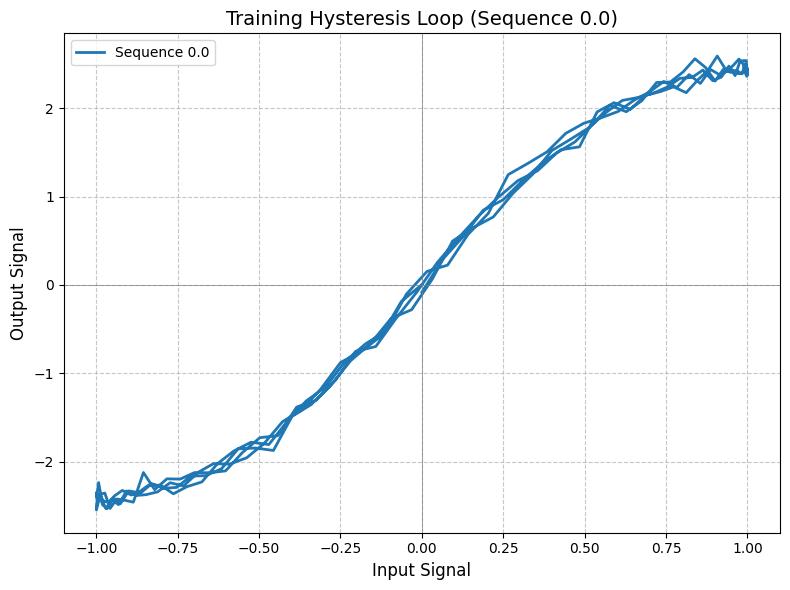

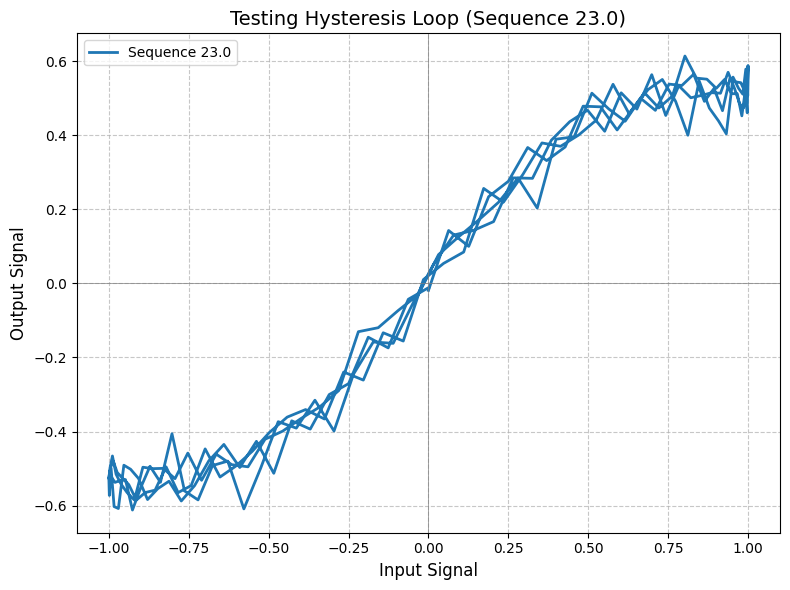

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Data Generation Functions ---

def generate_hysteresis_loop(input_signal, scale_x=1.0, scale_y=1.0, noise=0.0):
    """
    Simulate a hysteresis loop with shape parameters (scale_x, scale_y) and optional noise.

    Args:
        input_signal (np.ndarray): The input signal (e.g., a sine wave).
        scale_x (float): Scales the input signal before applying the non-linearity.
        scale_y (float): Scales the output signal.
        noise (float): Standard deviation of Gaussian noise to add to the output.

    Returns:
        np.ndarray: The simulated output signal exhibiting hysteresis.
    """
    input_scaled = scale_x * input_signal
    # The core hysteresis non-linearity: arctan for saturation, sin for loop shape
    output = scale_y * (np.arctan(input_scaled) + 0.2 * np.sin(2 * input_scaled))
    if noise > 0.0:
        output += np.random.normal(0, noise, size=output.shape)
    return output

def create_dataset(num_sequences=1000, sequence_length=200, test_size=0.2, random_seed=42):
    """
    Creates a dataset of simulated hysteresis loops, split into training and testing sets.

    Args:
        num_sequences (int): The total number of individual hysteresis sequences to generate.
        sequence_length (int): The number of data points in each sequence.
        test_size (float): The proportion of the dataset to include in the test split (0.0 to 1.0).
        random_seed (int): Seed for reproducibility of random number generation.

    Returns:
        tuple: A tuple containing two pandas DataFrames: (train_df, test_df).
               Each DataFrame contains 'sequence_id', 'input', and 'output' columns.
    """
    np.random.seed(random_seed) # Set seed for reproducibility

    all_inputs = []
    all_outputs = []
    all_ids = []

    print(f"Generating {num_sequences} hysteresis sequences, each with {sequence_length} data points...")

    for i in range(num_sequences):
        # Generate a smooth, oscillating input signal (e.g., a sine wave)
        # 4*np.pi ensures a few cycles for the hysteresis to develop
        t = np.linspace(0, 4 * np.pi, sequence_length)
        input_signal = np.sin(t)

        # Randomize hysteresis shape parameters and noise level for each sequence
        # This makes the dataset more diverse and robust for model training
        scale_x = np.random.uniform(0.5, 2.5) # Vary input scaling
        scale_y = np.random.uniform(0.5, 2.5) # Vary output scaling
        noise_level = np.random.uniform(0.0, 0.1) # Add a small amount of noise

        # Generate the output signal for the current sequence
        output_signal = generate_hysteresis_loop(input_signal, scale_x, scale_y, noise=noise_level)

        # Append data for the current sequence
        all_inputs.append(input_signal)
        all_outputs.append(output_signal)
        # Assign a unique ID to each sequence
        all_ids.append(np.full_like(input_signal, i))

    # Concatenate all sequences into single 1D arrays for DataFrame creation
    df = pd.DataFrame({
        'sequence_id': np.concatenate(all_ids),
        'input': np.concatenate(all_inputs),
        'output': np.concatenate(all_outputs)
    })

    # Split into training and testing sets based on unique sequence IDs
    # This ensures that entire sequences are either in the train or test set, not split across them
    unique_ids = df['sequence_id'].unique()
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_seed)

    # Filter the DataFrame to create training and testing DataFrames
    train_df = df[df['sequence_id'].isin(train_ids)].reset_index(drop=True)
    test_df = df[df['sequence_id'].isin(test_ids)].reset_index(drop=True)

    print(f"Dataset created: {len(train_ids)} training sequences, {len(test_ids)} test sequences.")
    return train_df, test_df

# --- Visualization Function ---

def plot_sample_sequence(df, sequence_id, title_prefix="Hysteresis Loop"):
    """
    Plots a single hysteresis loop from a DataFrame given its sequence ID.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'sequence_id', 'input', and 'output' columns.
        sequence_id (int): The ID of the sequence to plot.
        title_prefix (str): Prefix for the plot title.
    """
    sample = df[df['sequence_id'] == sequence_id]
    if sample.empty:
        print(f"Sequence ID {sequence_id} not found in the provided DataFrame.")
        return

    plt.figure(figsize=(8, 6))
    plt.plot(sample['input'], sample['output'], label=f'Sequence {sequence_id}', linewidth=2)
    plt.xlabel('Input Signal', fontsize=12)
    plt.ylabel('Output Signal', fontsize=12)
    plt.title(f'{title_prefix} (Sequence {sequence_id})', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.tight_layout()

# --- Main Execution ---

if __name__ == "__main__":
    # Define parameters for data generation
    NUM_SEQUENCES = 2000  # Total number of hysteresis loops to generate
    SEQUENCE_LENGTH = 200 # Number of data points per loop
    TEST_SPLIT_RATIO = 0.2 # 20% of sequences for testing
    RANDOM_SEED = 42      # For reproducibility

    # Generate the training and testing datasets
    train_data_df, test_data_df = create_dataset(
        num_sequences=NUM_SEQUENCES,
        sequence_length=SEQUENCE_LENGTH,
        test_size=TEST_SPLIT_RATIO,
        random_seed=RANDOM_SEED
    )

    print("\n--- Dataset Summary ---")
    print(f"Total data points in training set: {len(train_data_df)}")
    print(f"Total data points in testing set: {len(test_data_df)}")
    print(f"Number of unique training sequences: {train_data_df['sequence_id'].nunique()}")
    print(f"Number of unique testing sequences: {test_data_df['sequence_id'].nunique()}")

    # Example: Plot a sample from the training data
    if train_data_df['sequence_id'].nunique() > 0:
        sample_train_id = train_data_df['sequence_id'].unique()[0]
        print(f"\nPlotting a sample from the training set (Sequence ID: {sample_train_id})...")
        plot_sample_sequence(train_data_df, sample_train_id, title_prefix="Training Hysteresis Loop")
    else:
        print("\nNo training sequences to plot.")

    # Example: Plot a sample from the testing data
    if test_data_df['sequence_id'].nunique() > 0:
        sample_test_id = test_data_df['sequence_id'].unique()[0]
        print(f"\nPlotting a sample from the testing set (Sequence ID: {sample_test_id})...")
        plot_sample_sequence(test_data_df, sample_test_id, title_prefix="Testing Hysteresis Loop")
    else:
        print("\nNo testing sequences to plot.")

    # How to access the data in a list of numpy arrays (like your original curr_train, flow_train)
    # This part is for demonstration if you need the data in that specific format
    curr_train_list, flow_train_list = [], []
    for seq_id in train_data_df['sequence_id'].unique():
        seq_data = train_data_df[train_data_df['sequence_id'] == seq_id]
        curr_train_list.append(seq_data['input'].values)
        flow_train_list.append(seq_data['output'].values)

    curr_test_list, flow_test_list = [], []
    for seq_id in test_data_df['sequence_id'].unique():
        seq_data = test_data_df[test_data_df['sequence_id'] == seq_id]
        curr_test_list.append(seq_data['input'].values)
        flow_test_list.append(seq_data['output'].values)

    # Convert lists of arrays to a single numpy array (if all sequences have same length)
    # Be cautious: if sequence_length varies, this will create an array of objects
    curr_train_np = np.array(curr_train_list)
    flow_train_np = np.array(flow_train_list)
    curr_test_np = np.array(curr_test_list)
    flow_test_np = np.array(flow_test_list)

    print("\n--- Data in NumPy Array Format (for model input) ---")
    print(f"Shape of curr_train_np: {curr_train_np.shape}")
    print(f"Shape of flow_train_np: {flow_train_np.shape}")
    print(f"Shape of curr_test_np: {curr_test_np.shape}")
    print(f"Shape of flow_test_np: {flow_test_np.shape}")


# Train the Model

In [69]:
sequence_length = 200
inputs = Input(shape=(sequence_length, 1))
hysteron_output = PriesachHysteronArray(num_hysterons=10)(inputs)
lstm_output = GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(hysteron_output)
dense1 = TimeDistributed(Dense(32, activation='relu'))(lstm_output)
drop1 = Dropout(0.5)(dense1)
dense2 = TimeDistributed(Dense(16, activation='relu'))(drop1)
final_output = TimeDistributed(Dense(1))(dense2)

In [70]:
model = Model(inputs=inputs, outputs=final_output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ priesach_hysteron_array_3       │ (None, 200, 10)        │            30 │
│ (PriesachHysteronArray)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 200, 32)        │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 200, 32)        │         1,056 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 200, 16)        │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 200, 1)         │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,855 (22.87 KB)

 Trainable params: 5,855 (22.87 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model.fit(curr_train_np, flow_train_np, batch_size=10, epochs=10, validation_split=0.2)

Epoch 1/10


128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - loss: 1.1813 - val_loss: 0.3750
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.4346 - val_loss: 0.3249
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.3918 - val_loss: 0.3214
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.3629 - val_loss: 0.3035
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.3449 - val_loss: 0.3376
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.3231 - val_loss: 0.3041
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.3098 - val_loss: 0.3032
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.3152 - val_loss: 0.3265
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.3021 - val_loss: 0.3058
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.3164 - val_loss: 0.3048


In [72]:
curr_train_np.shape

(1600, 200)

In [73]:
prediction = model.predict(curr_test_np)

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step


In [74]:
prediction.shape

(400, 200, 1)

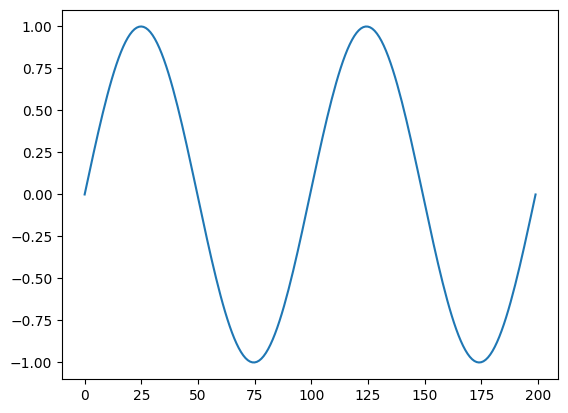

In [75]:
plt.plot(curr_train_np[0])

In [79]:
curr_train_np[0].shape

(200,)

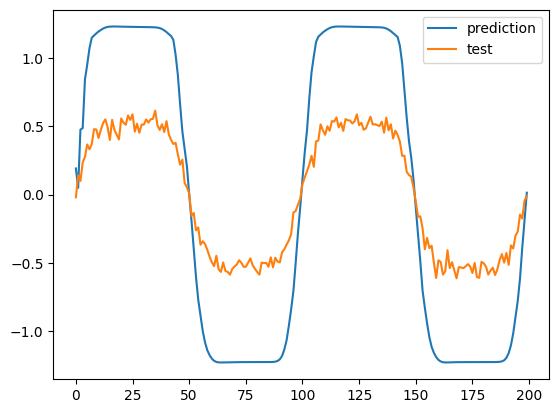

In [78]:
plt.plot(prediction[0], label='prediction')
plt.plot(flow_test_np[0], label="test")
plt.legend()